In [1]:
import csv
import math
import random
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.ensemble import BaggingRegressor
import pickle
from copy import deepcopy

In [2]:
def process_df(df):
  new_df = deepcopy(df)
  new_df.drop(columns=["id", "sale_date", "address", "latitude_rad", "longitude_rad", "latitude", "longitude", "psm"], inplace=True)
  new_df = pd.get_dummies(new_df, columns=["flat_type", "flat_model", "town"], dummy_na = True, dtype=np.uint8)
  new_df.drop(columns=["town_nan", "flat_type_nan", "flat_model_nan"], inplace=True)
  return new_df

In [3]:
def train_test_split_sample(df, startMonth, endMonth):
    sample_df = df[df.sale_month.isin(list(range(startMonth, endMonth)))]
    sample_X, sample_y = sample_df.drop('cpi_psm', axis=1), sample_df.cpi_psm
    return sample_X, sample_y

In [4]:
def train_test_split_year(df, lookback_years):
    latest_month = df.sale_month.max()
    test_months = list(range(latest_month - lookback_years * 12, latest_month + 1))
    train_months = list(range(1, latest_month - lookback_years * 12))

    train = df[df.sale_month.isin(train_months)]
    test = df[df.sale_month.isin(test_months)]
  
    X_train, y_train = train[train.columns.difference(["cpi_psm"])], train["cpi_psm"]
    X_test, y_test = test[test.columns.difference(["cpi_psm"])], test["cpi_psm"]
    
    return X_train, X_test, y_train, y_test

In [5]:
PROCESSED_DATA_PATH = os.path.join("../", "../", "data_processed", "resale_flat_prices")
SEED = 42

In [6]:
df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "engineered_data.csv"))
df.head(10)

,id,town,flat_type,flat_model,sale_date,floor,age,relative_tenure,floor_area,psm,...,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora
0,1,JURONG_WEST,3_ROOM,IMPROVED,1990-01-01,5.0,16,0.899953,70.0,334.285714,...,0.798752,0.195397,0.761661,0.541789,0.947906,0.904104,1,61.9,595.125779,NaN
1,2,OTHER,5_ROOM,STANDARD,1990-01-01,5.0,15,0.902280,120.0,916.666667,...,3.042559,0.090376,1.133326,0.159056,0.330270,1.954674,1,61.9,1631.933226,NaN
2,3,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,5.0,15,0.902280,63.0,722.222222,...,1.148847,0.446105,0.850333,0.943485,0.737703,0.932695,1,61.9,1285.765572,NaN
3,4,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,251.724138,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,NaN
4,5,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,11.0,21,0.887322,29.0,251.724138,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,NaN
5,6,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,310.344828,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,552.504039,NaN
6,7,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,8.0,7,0.918820,64.0,687.500000,...,1.018641,0.485058,0.986821,0.800866,0.808590,0.940111,1,61.9,1223.949919,NaN
7,8,BUKIT_MERAH,3_ROOM,MODEL_A,1990-01-01,8.0,6,0.920652,74.0,1128.378378,...,1.089870,0.544915,0.567711,0.490547,0.708861,0.799126,1,61.9,2008.841636,NaN
8,9,BUKIT_MERAH,3_ROOM,MODEL_A,1990-01-01,5.0,6,0.920652,73.0,1150.684932,...,1.657478,0.053197,0.982875,0.340834,1.013329,0.940071,1,61.9,2048.553788,NaN
9,10,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,2.0,15,0.902280,76.0,671.052632,...,0.690789,0.083148,0.637859,0.507003,0.406147,1.175060,1,61.9,1194.668821,NaN


In [7]:
df["is_imputted_sora"] = np.where(df["avg_sora"].isnull(), True, False)

imp = SimpleImputer()
df["avg_sora"] = imp.fit_transform(df["avg_sora"].to_numpy().reshape(-1, 1))

In [8]:
df.describe()

,id,floor,age,relative_tenure,floor_area,psm,latitude,longitude,latitude_rad,longitude_rad,...,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora
count,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,...,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000
mean,432914.000000,7.626058,17.349350,0.892896,96.135123,3173.083607,1.497366,103.148474,0.026134,1.800280,...,62.788172,61.708270,62.231490,61.990540,62.338973,62.217020,190.483063,82.131055,4131.625468,0.763427
std,249942.870098,4.738340,10.217708,0.029046,25.796313,1385.776553,2.612377,11.573640,0.045595,0.201998,...,923.588875,923.284911,923.497181,923.502716,923.385468,923.496916,104.298678,11.879488,1363.166128,0.659903
min,1.000000,2.000000,0.000000,0.731586,28.000000,161.290323,-37.840251,-122.683299,-0.660437,-2.141228,...,0.007724,0.000003,0.000790,0.042886,0.021691,0.018401,1.000000,61.900000,284.387097,0.035633
25%,216457.500000,5.000000,9.000000,0.878870,73.000000,2266.666667,1.335322,103.772049,0.023306,1.811164,...,0.754831,0.076599,0.395358,0.241143,0.477918,0.375599,107.000000,73.400000,3321.083800,0.260618
50%,432914.000000,8.000000,16.000000,0.899953,93.000000,2870.370370,1.355961,103.843296,0.023666,1.812407,...,1.136412,0.112533,0.610644,0.370503,0.705703,0.585058,175.000000,76.500000,4031.953168,0.763427
75%,649370.500000,11.000000,24.000000,0.915007,114.000000,3990.180006,1.383056,103.897860,0.024139,1.813360,...,1.559133,0.156376,0.869802,0.540301,0.994037,0.853369,269.000000,95.900000,4868.754343,0.763427
max,865827.000000,50.000000,55.000000,0.930702,307.000000,13310.344828,50.820779,145.019498,0.886990,2.531068,...,16929.865540,16924.138572,16928.066230,16927.190593,16926.344996,16927.966733,393.000000,110.200000,14163.126574,3.414986


In [9]:
new_df = process_df(df)
sample_X, sample_y = train_test_split_sample(new_df, 200, 236)

In [10]:
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=SEED), random_state=SEED)

# GridSearchCV

In [11]:
parameters = {'n_estimators':[50,100,200], 'max_samples':[0.1,0.25,0.5,0.75,1.0], 'max_features':[0.1,0.25,0.5,0.75,1.0]}
grid = GridSearchCV(model, parameters, scoring='neg_root_mean_squared_error', verbose = 4, return_train_score = True)
grid.fit(X=sample_X, y=sample_y)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END max_features=0.1, max_samples=0.1, n_estimators=50;, score=(train=-592.365, test=-616.445) total time=   4.2s
[CV 2/5] END max_features=0.1, max_samples=0.1, n_estimators=50;, score=(train=-595.377, test=-626.327) total time=   2.9s
[CV 3/5] END max_features=0.1, max_samples=0.1, n_estimators=50;, score=(train=-583.358, test=-673.703) total time=   2.8s
[CV 4/5] END max_features=0.1, max_samples=0.1, n_estimators=50;, score=(train=-584.203, test=-686.391) total time=   2.5s
[CV 5/5] END max_features=0.1, max_samples=0.1, n_estimators=50;, score=(train=-576.851, test=-722.105) total time=   2.4s
[CV 1/5] END max_features=0.1, max_samples=0.1, n_estimators=100;, score=(train=-576.832, test=-596.581) total time=   4.9s
[CV 2/5] END max_features=0.1, max_samples=0.1, n_estimators=100;, score=(train=-576.696, test=-610.020) total time=   5.2s
[CV 3/5] END max_features=0.1, max_samples=0.1, n_estimators=100;, score=(t

[CV 2/5] END max_features=0.1, max_samples=1.0, n_estimators=100;, score=(train=-435.312, test=-520.563) total time=  19.6s
[CV 3/5] END max_features=0.1, max_samples=1.0, n_estimators=100;, score=(train=-429.407, test=-548.621) total time=  20.9s
[CV 4/5] END max_features=0.1, max_samples=1.0, n_estimators=100;, score=(train=-428.822, test=-565.241) total time=  19.5s
[CV 5/5] END max_features=0.1, max_samples=1.0, n_estimators=100;, score=(train=-419.484, test=-629.481) total time=  19.1s
[CV 1/5] END max_features=0.1, max_samples=1.0, n_estimators=200;, score=(train=-414.681, test=-519.506) total time=  40.7s
[CV 2/5] END max_features=0.1, max_samples=1.0, n_estimators=200;, score=(train=-420.579, test=-511.573) total time=  35.3s
[CV 3/5] END max_features=0.1, max_samples=1.0, n_estimators=200;, score=(train=-414.355, test=-542.768) total time=  32.7s
[CV 4/5] END max_features=0.1, max_samples=1.0, n_estimators=200;, score=(train=-414.163, test=-553.867) total time=  35.5s
[CV 5/5]

[CV 3/5] END max_features=0.25, max_samples=0.75, n_estimators=200;, score=(train=-183.453, test=-402.564) total time=  50.0s
[CV 4/5] END max_features=0.25, max_samples=0.75, n_estimators=200;, score=(train=-191.293, test=-370.557) total time=  54.6s
[CV 5/5] END max_features=0.25, max_samples=0.75, n_estimators=200;, score=(train=-191.334, test=-430.000) total time=  51.4s
[CV 1/5] END max_features=0.25, max_samples=1.0, n_estimators=50;, score=(train=-182.058, test=-354.969) total time=  14.8s
[CV 2/5] END max_features=0.25, max_samples=1.0, n_estimators=50;, score=(train=-179.543, test=-369.894) total time=  14.8s
[CV 3/5] END max_features=0.25, max_samples=1.0, n_estimators=50;, score=(train=-170.803, test=-404.218) total time=  13.8s
[CV 4/5] END max_features=0.25, max_samples=1.0, n_estimators=50;, score=(train=-177.329, test=-367.293) total time=  13.9s
[CV 5/5] END max_features=0.25, max_samples=1.0, n_estimators=50;, score=(train=-179.205, test=-441.738) total time=  13.8s
[C

[CV 4/5] END max_features=0.5, max_samples=0.75, n_estimators=50;, score=(train=-140.128, test=-302.830) total time=  18.1s
[CV 5/5] END max_features=0.5, max_samples=0.75, n_estimators=50;, score=(train=-142.443, test=-328.101) total time=  20.8s
[CV 1/5] END max_features=0.5, max_samples=0.75, n_estimators=100;, score=(train=-141.541, test=-261.873) total time=  37.1s
[CV 2/5] END max_features=0.5, max_samples=0.75, n_estimators=100;, score=(train=-137.031, test=-317.063) total time=  39.6s
[CV 3/5] END max_features=0.5, max_samples=0.75, n_estimators=100;, score=(train=-126.997, test=-353.480) total time=  40.8s
[CV 4/5] END max_features=0.5, max_samples=0.75, n_estimators=100;, score=(train=-136.605, test=-298.681) total time=  38.7s
[CV 5/5] END max_features=0.5, max_samples=0.75, n_estimators=100;, score=(train=-138.807, test=-327.443) total time=  37.3s
[CV 1/5] END max_features=0.5, max_samples=0.75, n_estimators=200;, score=(train=-140.907, test=-261.921) total time= 1.3min
[C

[CV 5/5] END max_features=0.75, max_samples=0.5, n_estimators=100;, score=(train=-162.598, test=-307.669) total time=  43.5s
[CV 1/5] END max_features=0.75, max_samples=0.5, n_estimators=200;, score=(train=-164.304, test=-254.209) total time= 1.5min
[CV 2/5] END max_features=0.75, max_samples=0.5, n_estimators=200;, score=(train=-159.081, test=-307.447) total time= 1.5min
[CV 3/5] END max_features=0.75, max_samples=0.5, n_estimators=200;, score=(train=-147.446, test=-333.232) total time= 1.5min
[CV 4/5] END max_features=0.75, max_samples=0.5, n_estimators=200;, score=(train=-159.412, test=-292.762) total time= 1.5min
[CV 5/5] END max_features=0.75, max_samples=0.5, n_estimators=200;, score=(train=-160.962, test=-309.134) total time= 1.5min
[CV 1/5] END max_features=0.75, max_samples=0.75, n_estimators=50;, score=(train=-132.581, test=-252.601) total time=  30.4s
[CV 2/5] END max_features=0.75, max_samples=0.75, n_estimators=50;, score=(train=-128.552, test=-308.420) total time=  30.1s


[CV 1/5] END max_features=1.0, max_samples=0.5, n_estimators=50;, score=(train=-168.520, test=-265.714) total time=  29.0s
[CV 2/5] END max_features=1.0, max_samples=0.5, n_estimators=50;, score=(train=-162.060, test=-315.407) total time=  31.5s
[CV 3/5] END max_features=1.0, max_samples=0.5, n_estimators=50;, score=(train=-150.735, test=-336.557) total time=  29.9s
[CV 4/5] END max_features=1.0, max_samples=0.5, n_estimators=50;, score=(train=-163.569, test=-300.510) total time=  29.3s
[CV 5/5] END max_features=1.0, max_samples=0.5, n_estimators=50;, score=(train=-165.396, test=-315.519) total time=  29.9s
[CV 1/5] END max_features=1.0, max_samples=0.5, n_estimators=100;, score=(train=-165.008, test=-261.153) total time= 1.1min
[CV 2/5] END max_features=1.0, max_samples=0.5, n_estimators=100;, score=(train=-159.287, test=-310.504) total time= 1.1min
[CV 3/5] END max_features=1.0, max_samples=0.5, n_estimators=100;, score=(train=-148.255, test=-335.931) total time= 1.3min
[CV 4/5] END 

GridSearchCV(estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=42),
                                        random_state=42),
             param_grid={'max_features': [0.1, 0.25, 0.5, 0.75, 1.0],
                         'max_samples': [0.1, 0.25, 0.5, 0.75, 1.0],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=4)

In [12]:
print("Best Score: %f" % grid.best_score_) 
print("Best params: ", grid.best_params_)

Best Score: -292.229730
Best params:  {'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 200}


In [13]:
pickle.dump(grid, open("grid_dt_v2_bagging.sav", "wb"))

In [14]:
model = grid.best_estimator_

X_train, X_test, y_train, y_test = train_test_split_year(new_df, 4)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.7997855445137825

In [15]:
pickle.dump(model, open("model_dt_v2_bagging.pkl", "wb"))

# Metrics

In [16]:
def produce_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  rtwo = r2_score(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  mdape = median_absolute_error(y_test, y_pred)/np.median(y_test)
  return mse, mse**(0.5), mae, rtwo, mape, mdape

In [17]:
mse, rmse, mae, rtwo, mape, mdape = produce_metrics(y_test, y_pred)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {rtwo}")
print(f"MAPE: {mape}")
print(f"MdAPE: {mdape}")

MSE: 399350.6124037095
RMSE: 631.9419375256792
MAE: 460.7829263525707
R2: 0.7997855445137825
MAPE: 0.08243560544411317
MdAPE: 0.06856250352546049


# Feature Importance

In [19]:
# Unlike the other models, we have to calculate feature importances manually.
# For each base estimator (DecisionTreeRegressor), find the subset of features it used and the feature importance of each used feature.
# Then, average the feature importances of all the features used over all base estimators. 

feature_num_dict = {}

estimator_features = model.estimators_features_

for i in range(len(model.estimators_)):
    impts = (model.estimators_[i].feature_importances_) 
    feats = estimator_features[i] # Array of the indexes of the features used, not array of features names. 
    for j in range(len(feats)):
        if feats[j] not in feature_num_dict:
            feature_num_dict[feats[j]] = np.array([])
        feature_num_dict[feats[j]] = np.append(feature_num_dict[feats[j]], impts[j])

# Average out the importances for each feature 
for feature_num in feature_num_dict:
    feature_num_dict[feature_num] = np.average(feature_num_dict[feature_num])

feature_impts = {}

for feature_num, importance in feature_num_dict.items():
    feature_impts[model.feature_names_in_[feature_num]] = importance
feature_impts = dict(sorted(feature_impts.items(), key=lambda item: item[1], reverse=True)) # sort
print(feature_impts)

{'sale_month': 0.6043833392586342, 'cpi': 0.17365271224785697, 'floor_area': 0.07882861851942743, 'nearest_bus_stops': 0.05892113643405805, 'avg_sora': 0.033935875258962224, 'relative_tenure': 0.032473071709405534, 'nearest_hawkers': 0.0323302044117658, 'age': 0.032038404681055746, 'floor': 0.03007055166585461, 'nearest_trains': 0.02206301703421409, 'nearest_post_offices': 0.01766331682574873, 'nearest_libraries': 0.015420425202753772, 'town_BISHAN': 0.01486991828570871, 'nearest_parks': 0.014640434025640659, 'flat_type_4_ROOM': 0.01422975226253626, 'nearest_pharmacies': 0.013973274625341214, 'town_WOODLANDS': 0.01334375435963607, 'nearest_primary_schools': 0.012015376994597107, 'town_JURONG_WEST': 0.011129884777960973, 'town_BUKIT_MERAH': 0.010800041120641498, 'nearest_atm': 0.01026102094670393, 'town_OTHER': 0.00989509184932236, 'flat_type_3_ROOM': 0.009405862501442859, 'nearest_stores': 0.008204398405313411, 'town_YISHUN': 0.006372489870181177, 'town_TOA_PAYOH': 0.00545602725031801,

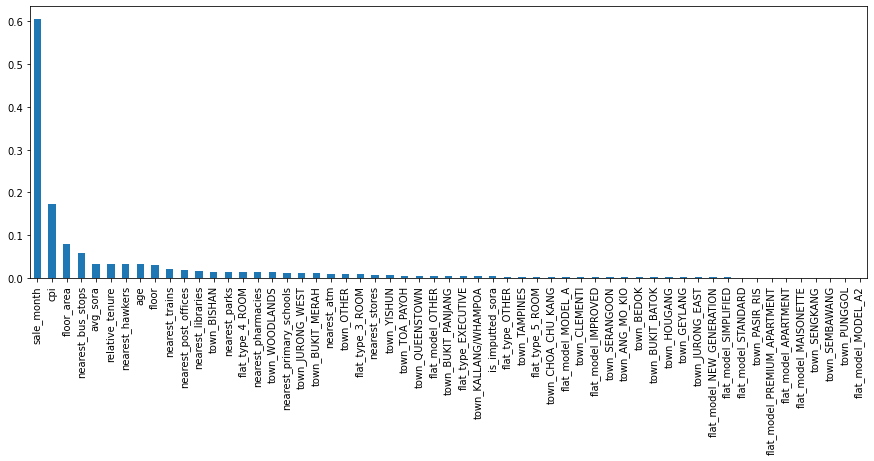

In [20]:
features_series = pd.Series(feature_impts.values(), index=feature_impts.keys())
features_series.sort_values(ascending=False,inplace=True)
plt.figure(figsize=(15,5))
features_series.plot(kind = 'bar')
plt.show()

# Actual vs Predicted

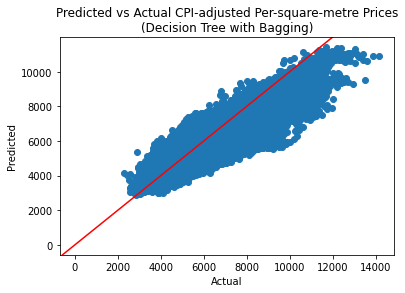

In [21]:
fig, ax = plt.subplots()
ax.axline((0, 0), slope=1, color="red")
plt.scatter(y_test, y_pred)
plt.title("Predicted vs Actual CPI-adjusted Per-square-metre Prices\n(Decision Tree with Bagging)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()